# Building an E-Commerce clothing classifier model using CNNs

Fashion Forward is a new AI-based e-commerce clothing retailer. They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

I will build, train and evaluate a convolutional neural network using the data from Fashion-MNIST.

The data is available on kaggle here: https://www.kaggle.com/datasets/zalando-research/fashionmnist

## Approach

1. Load the data and preprocess it into training (80% of the train data) and validation data (20% of the train data).
2. Inspect the data.
3. Create the CNN model.
4. Train the CNN model and save the best model to use on the test dataset.
5. Make predictions on the test dataset and inspect the results.

In [1]:
# Load packages

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import classification_report
import copy

In [2]:
# Load datasets

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
# Split train dataset into train and validation sets

# Extract data and labels
X = []
y = []

for image, label in train_data:
    X.append(image)
    y.append(label)

X = torch.stack(X)  
y = torch.tensor(y) 

# Split datasets making sure to stratify the data to ensure no class imbalance

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create dataloaders

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Extract data and labels for test data too
X = []
y = []

for image, label in test_data:
    X.append(image)
    y.append(label)

X_test = torch.stack(X)  
y_test = torch.tensor(y) 

test_dataset = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([32, 1, 28, 28])
Number of classes:  10
Class names: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
T-shirt/top - 6000
Trouser - 6000
Pullover - 6000
Dress - 6000
Coat - 6000
Sandal - 6000
Shirt - 6000
Sneaker - 6000
Bag - 6000
Ankle boot - 6000


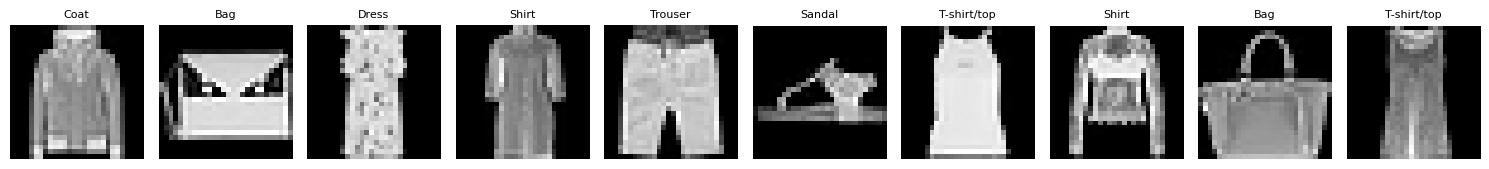

Fashion MNIST train -  rows: 48000  columns: torch.Size([1, 28, 28])
Fashion MNIST valid -  rows: 12000  columns: torch.Size([1, 28, 28])
Fashion MNIST test -  rows: 10000  columns: torch.Size([1, 28, 28])


In [4]:
# Explore the data to understand how to create the model

image, label = next(iter(dataloader_train))
print(image.shape)
print("Number of classes: ", len(train_data.classes))
print("Class names:", ', '.join(train_data.classes))

# Number of items per class
label_counts = Counter(train_data.targets.numpy()) 
for idx, count in sorted(label_counts.items()):
    print(f"{train_data.classes[idx]} - {count}")

# Plot example images
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(image[i].squeeze(), cmap="gray")
    axs[i].set_title(f"{train_data.classes[label[i]]}", fontsize=8)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

In [5]:
# Defining a first pass of the CNN model

class neuralModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.classifier = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

net = neuralModel(num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= 0.001)

summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
               ELU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
               ELU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                   [-1, 10]          31,370
Total params: 50,378
Trainable params: 50,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.96
Params size (MB): 0.19
Estimated Tot

In [6]:
# train the model and save best model

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_val_accuracy = 0.0 # Keep track of best accuracy as well, might be useful for logging
best_epoch = -1
best_model_state = None
epochs_no_improve = 0 

for epoch in range(15):
    net.train()  # Training mode
    running_loss = 0
    num_processed = 0
    correct_train = 0
    total_train = 0

    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_processed += len(labels)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    avg_train_loss = running_loss / num_processed
    train_losses.append(avg_train_loss)
    
    print(f'Epoch {epoch+1}, Train loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

    # --- Validation ---
    net.eval()  # Evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in dataloader_val:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    avg_val_loss = val_loss / total_val
    val_losses.append(avg_val_loss)
    
    print(f'Validation loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')   
    
    # Check if this is the best model so far
    is_best = False
    if avg_val_loss < best_val_loss:  
        best_val_loss = avg_val_loss
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        best_model_state = copy.deepcopy(net.state_dict())
        epochs_no_improve = 0
        is_best = True
        print(f'NEW BEST MODEL at epoch {epoch+1}! Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    else:
        epochs_no_improve += 1
        
    # Save the best model
    if is_best:
        torch.save({
            'epoch': best_epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'val_accuracy': best_val_accuracy,
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy
        }, f'bestModel.pt')

Epoch 1, Train loss: 0.0127, Accuracy: 0.8584
Validation loss: 0.0098, Accuracy: 0.8882
NEW BEST MODEL at epoch 1! Val Loss: 0.0098, Val Acc: 0.8882
Epoch 2, Train loss: 0.0087, Accuracy: 0.9012
Validation loss: 0.0084, Accuracy: 0.9073
NEW BEST MODEL at epoch 2! Val Loss: 0.0084, Val Acc: 0.9073
Epoch 3, Train loss: 0.0075, Accuracy: 0.9133
Validation loss: 0.0087, Accuracy: 0.9039
Epoch 4, Train loss: 0.0067, Accuracy: 0.9235
Validation loss: 0.0079, Accuracy: 0.9151
NEW BEST MODEL at epoch 4! Val Loss: 0.0079, Val Acc: 0.9151
Epoch 5, Train loss: 0.0061, Accuracy: 0.9298
Validation loss: 0.0084, Accuracy: 0.9097
Epoch 6, Train loss: 0.0054, Accuracy: 0.9384
Validation loss: 0.0087, Accuracy: 0.9090
Epoch 7, Train loss: 0.0049, Accuracy: 0.9436
Validation loss: 0.0083, Accuracy: 0.9159
Epoch 8, Train loss: 0.0045, Accuracy: 0.9491
Validation loss: 0.0081, Accuracy: 0.9180
Epoch 9, Train loss: 0.0041, Accuracy: 0.9535
Validation loss: 0.0087, Accuracy: 0.9147
Epoch 10, Train loss: 0.0

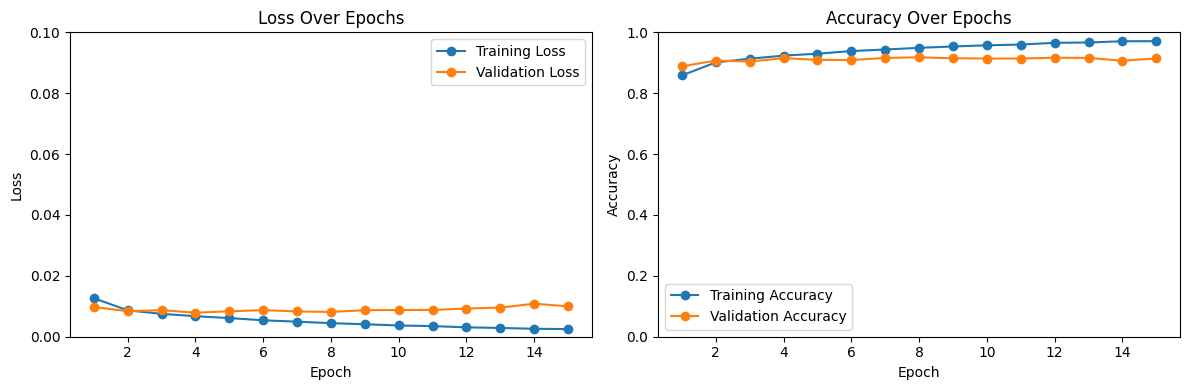

In [7]:
# Plotting the train and validation accuracy and loss.

epochs = range(1, 16)

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.ylim(0, 0.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)  
plt.plot(epochs, train_accuracies, 'o-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'o-', label='Validation Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Results

My modest convolutional neural network achieved a validation accuracy of 91% after 15 epochs, which is sufficient for this project's goals given the dataset's size.

While the model performed well, I observed overfitting beginning around epoch 4. At this point, the training accuracy continued to improve, but the validation accuracy peaked and did not show further gains.

Although further enhancements like dropout layers, weight decay, data augmentation, or hyperparameter tuning could potentially boost performance, the current 91% accuracy is acceptable. I've saved the best model parameters to use for predictions on the test dataset.

In [8]:
# Evaluate the accuracy on the unseen test dataset, and calculate precision and recall on each class

# Load the best model checkpoint from file
checkpoint = torch.load('bestModel.pt')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(f"Loaded best model from epoch {checkpoint['epoch']} "
      f"with Val Loss: {checkpoint['val_loss']:.4f}, "
      f"Val Acc: {checkpoint['val_accuracy']:.4f}")


# Collect all true and predicted labels
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for image, label in dataloader_test:
        output = net(image.reshape(-1, 1, 28, 28))
        pred = torch.argmax(output, dim=1)
        y_pred.extend(pred.cpu().numpy())
        y_true.extend(label.cpu().numpy())

# Generate classification report
class_names = train_data.classes 
print(classification_report(y_true, y_pred, target_names=class_names))


Loaded best model from epoch 4 with Val Loss: 0.0079, Val Acc: 0.9151
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.90      0.87      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.80      0.89      0.84      1000
       Dress       0.93      0.88      0.90      1000
        Coat       0.85      0.87      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.81      0.67      0.73      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



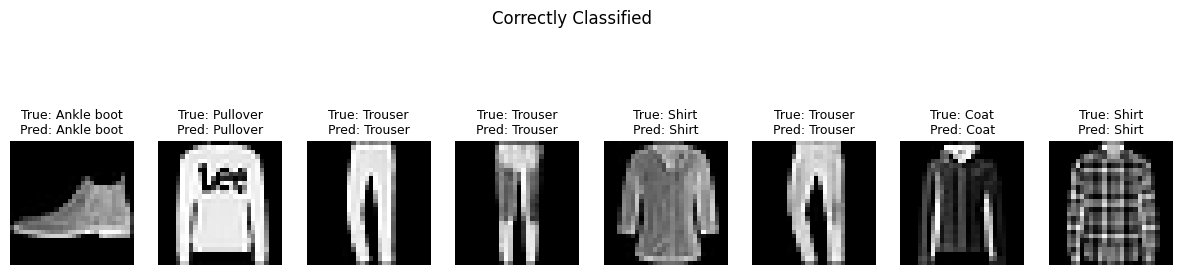

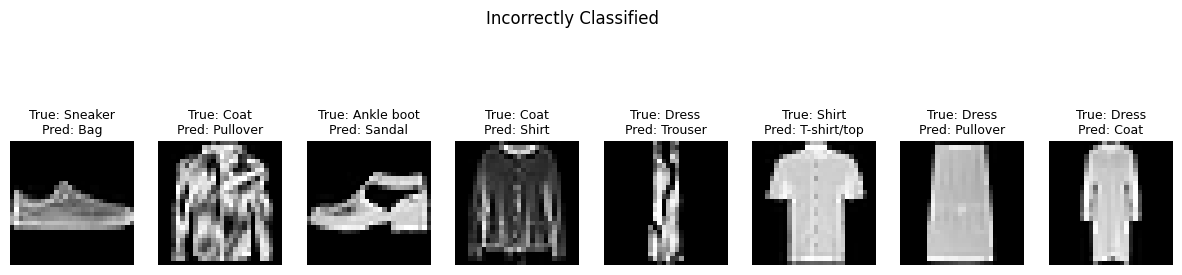

In [9]:
# Visualise some examples

# Store test images, predicted labels, true labels
correct_images = []
correct_preds = []
correct_labels = []

incorrect_images = []
incorrect_preds = []
incorrect_labels = []

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(labels)):
            if preds[i] == labels[i]:
                correct_images.append(images[i])
                correct_preds.append(preds[i].item())
                correct_labels.append(labels[i].item())
            else:
                incorrect_images.append(images[i])
                incorrect_preds.append(preds[i].item())
                incorrect_labels.append(labels[i].item())

# Class names
class_names = test_data.classes

# Helper function to show images
def show_images(images, true_labels, pred_labels, title, num_images=8):
    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        img = images[i].squeeze().cpu().numpy()
        true = class_names[true_labels[i]]
        pred = class_names[pred_labels[i]]
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true}\nPred: {pred}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize examples
show_images(correct_images, correct_labels, correct_preds, "Correctly Classified", num_images=8)
show_images(incorrect_images, incorrect_labels, incorrect_preds, "Incorrectly Classified", num_images=8)


### Test result.

The model achieved 91% accuracy on the test dataset. A closer look at individual clothing categories reveals that trousers, sandals, bags and boots were classified most accurately, while shirts had the lowest accuracy. Interestingly, even when misclassified, the model's predictions often resembled the actual item (e.g., a shirt mislabeled as a T-shirt, or a boot as a sandal).